<a href="https://colab.research.google.com/github/YuancongGou/seismoloGYC/blob/main/Copy_of_bring_your_own_seismogram_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![image](https://raw.githubusercontent.com/seisbench/seisbench/main/docs/_static/seisbench_logo_subtitle_outlined.svg)

*This code is necessary on colab to install SeisBench. If SeisBench is already installed on your machine, you can skip this.*

Modified from original example for Earthquake of the Week - EPS256 at Berkeley by Yuancong Gou : 
https://colab.research.google.com/github/seisbench/seisbench/blob/main/examples/02a_deploy_model_on_streams_example.ipynb

In [ ]:
!pip install seisbench -q

Using wandb to monitor CPU and GPU usage in Google colab.

In [ ]:
!pip install wandb -q
import wandb

*This cell is required to circumvent an issue with colab and obspy. For details, check this issue in the obspy documentation: https://github.com/obspy/obspy/issues/2547*

In [ ]:
try:
    import obspy
    obspy.read()
except TypeError:
    # Needs to restart the runtime once, because obspy only works properly after restart.
    print('Stopping RUNTIME. If you run this code for the first time, this is expected. Colaboratory will restart automatically. Please run again.')
    exit()

Google colab provides free GPU resources (also TPU), which can be accessed by changing the settings:

'Runtime'

'Change runtime time'

'GPU'

Then use 'nvidia-smi' to check the GPU

In [ ]:
!nvidia-smi

Wed Mar  9 05:53:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Quickly setting-up picking models

This tutorial shows how to use SeisBench to picks / detect events on the seismic streams. This notebook does not perform in-depth analysis of the resulting detection information, it just shows how you can quickly access and deploy a range of seismic models to seismic data. 


In [ ]:
import seisbench
import seisbench.models as sbm

### Creating a model

#### Here you can download your pretrained model for predicting on the example streams.
if you would like to see the full suite of available pre-trained weights for any model, you can call the ```list_pretrained``` method, which will return all the associated weights for the model, along with information on the training procedure for each set of weights. For the purposes of this plug-in-and-play example, we comment out a number of available models, for you to load and try out.


In [ ]:
sbm.PhaseNet.list_pretrained()

['ethz', 'geofon', 'instance', 'iquique', 'lendb', 'neic', 'scedc', 'stead']

In [ ]:
# Various pre-trained weights for PhaseNet
# pn_model = sbm.PhaseNet.from_pretrained("ethz")
# pn_model = sbm.PhaseNet.from_pretrained("instance")
# pn_model = sbm.PhaseNet.from_pretrained("scedc")
pn_model = sbm.PhaseNet.from_pretrained("stead")
#pn_model = sbm.PhaseNet.from_pretrained("geofon")
# pn_model = sbm.PhaseNet.from_pretrained("neic")

# Various pre-trained weights for EQT
#eqt_model = sbm.EQTransformer.from_pretrained("original")
# eqt_model = sbm.EQTransformer.from_pretrained("ethz")
# eqt_model = sbm.EQTransformer.from_pretrained("instance")
# eqt_model = sbm.EQTransformer.from_pretrained("scedc")
eqt_model = sbm.EQTransformer.from_pretrained("stead")
# eqt_model = sbm.EQTransformer.from_pretrained("geofon")

# Various pre-trained weights for GPD
# gpd_model = sbm.GPD.from_pretrained("original")
# gpd_model = sbm.GPD.from_pretrained("ethz")
# gpd_model = sbm.GPD.from_pretrained("scedc")
gpd_model = sbm.GPD.from_pretrained("stead")
# gpd_model = sbm.GPD.from_pretrained("geofon")
# gpd_model = sbm.GPD.from_pretrained("neic")

Downloading: 100%|██████████| 109k/109k [00:00<00:00, 2.28MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 9.70MB/s]
Downloading: 100%|██████████| 6.66M/6.66M [00:00<00:00, 22.2MB/s]


If GPU available, send models to GPU.

In [ ]:
pn_model.cuda();
eqt_model.cuda();
gpd_model.cuda();

#### Read in waveforms


In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

client = Client("NCEDC")


M 5.2 - 30km SE of Bodie, CA

2020-04-11 14:36:37 (UTC) 38.053°N 118.733°W 8.5 km depth

https://earthquake.usgs.gov/earthquakes/eventpage/nc73367270/executive

We will look at the data from a nearby station NC.MINS

latitude:
longitude:

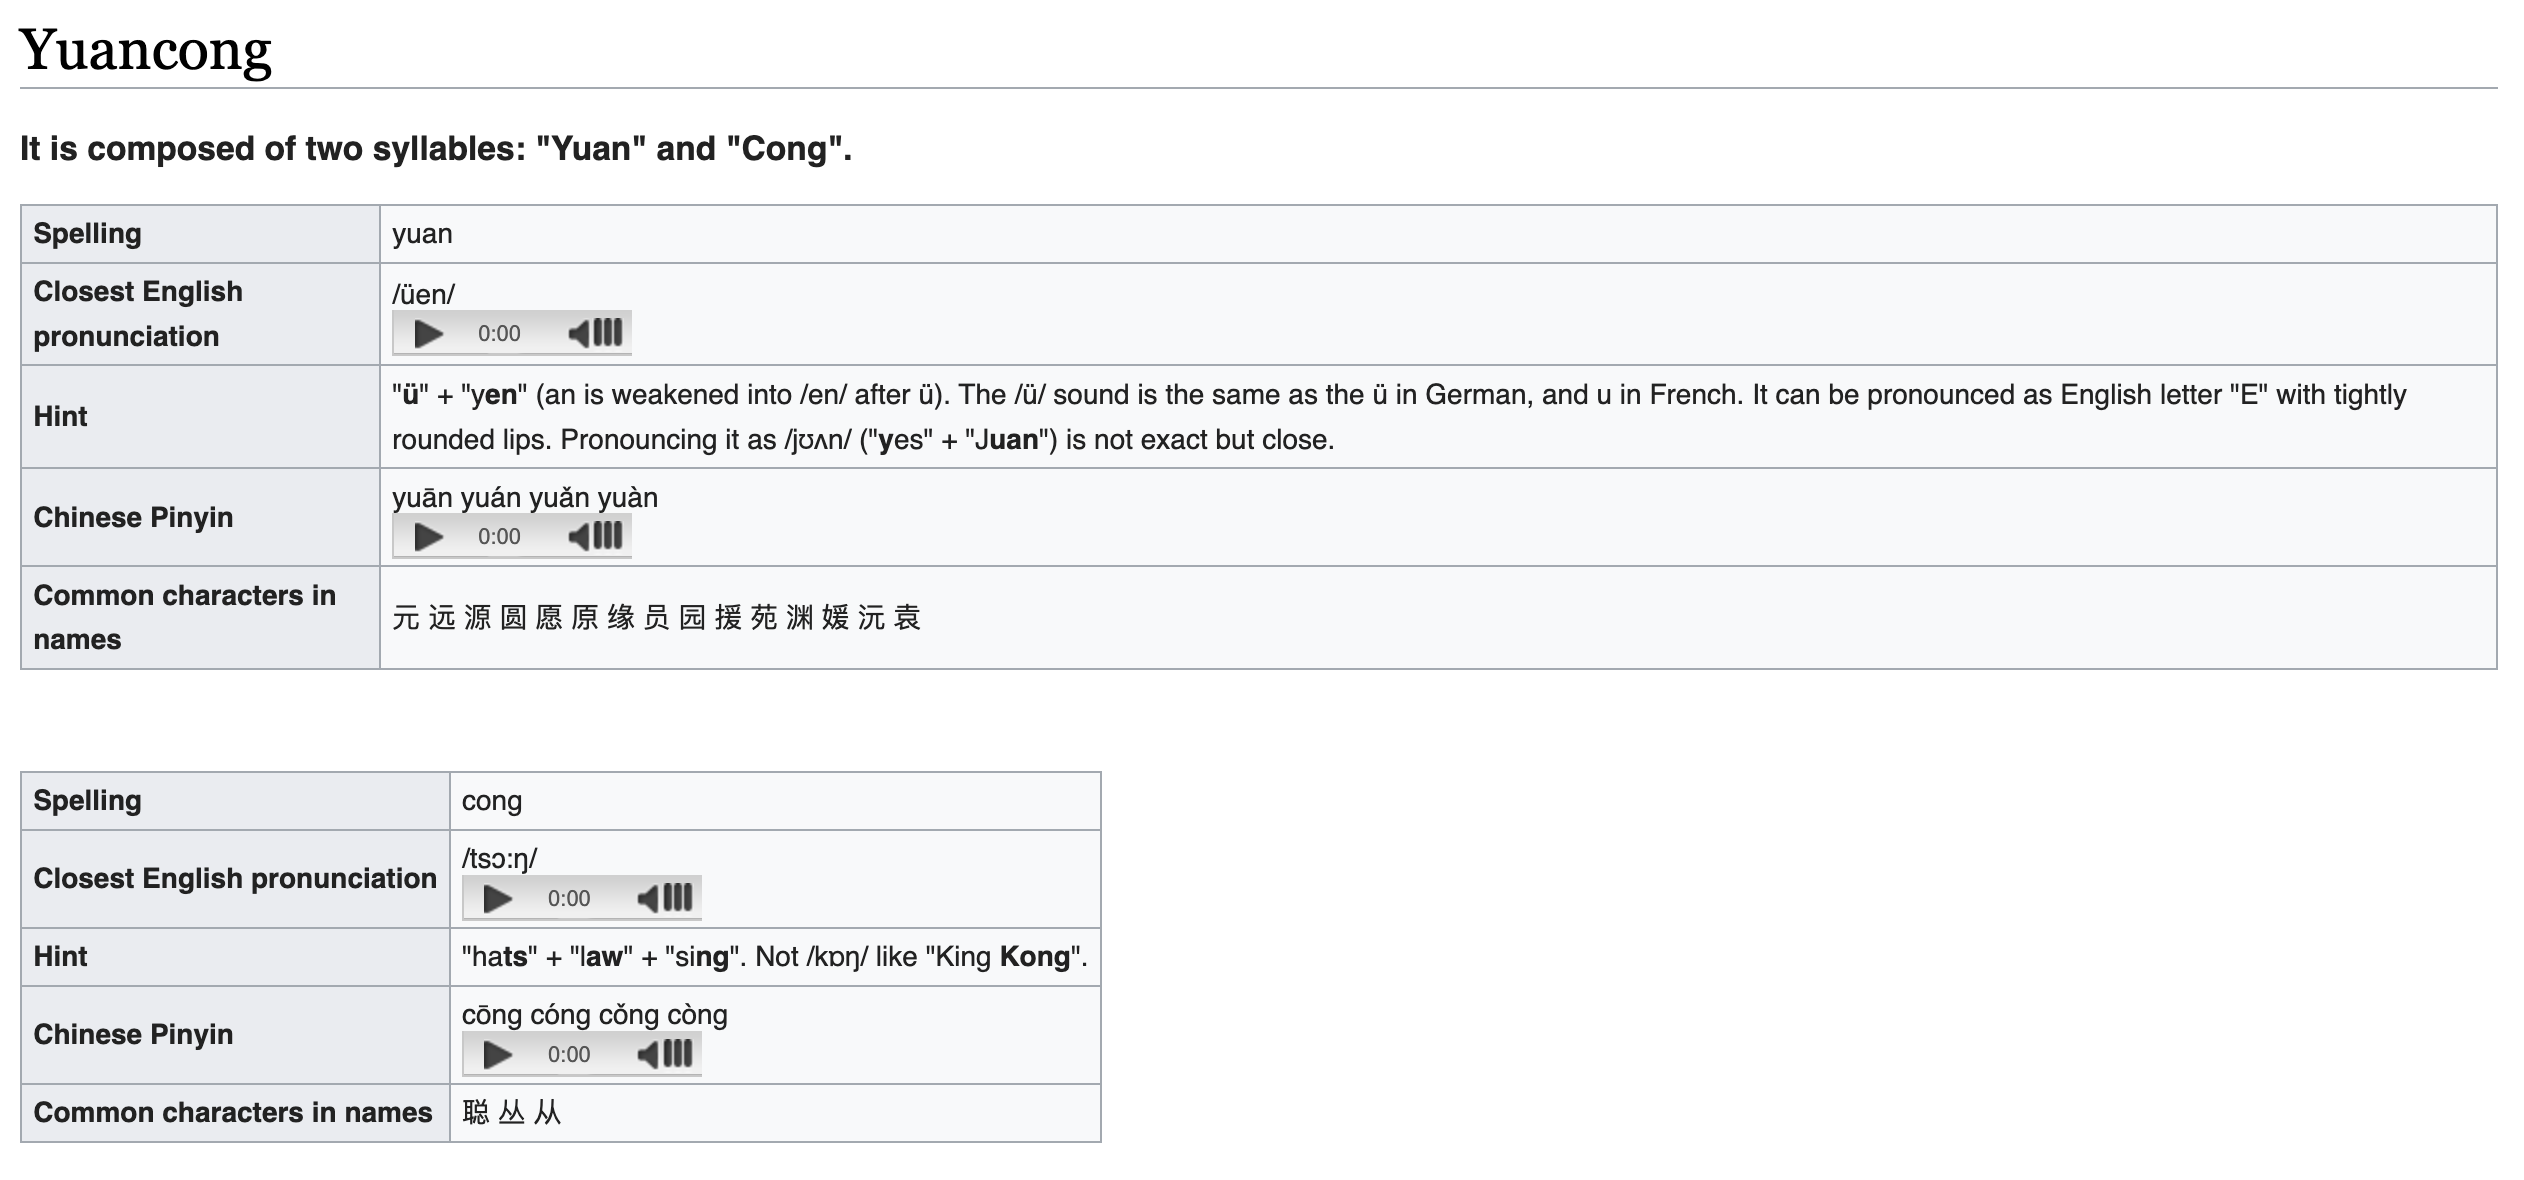

In [ ]:
t1_download = UTCDateTime(2020, 4, 11, 00, 00, 00)
t2_download = UTCDateTime(2020, 4, 12, 00, 00, 00)
stream = client.get_waveforms(network="NC", station="MINS", location="*", channel="HH?", starttime=t1_download, endtime=t2_download)

In [ ]:
otime = UTCDateTime(2020, 4, 11, 14, 36, 37)
stime = otime - 600
etime = stream[0].stats.endtime

stream.trim(stime,etime)
#stream.plot()

3 Trace(s) in Stream:
NC.MINS..HHE | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples
NC.MINS..HHN | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples
NC.MINS..HHZ | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples

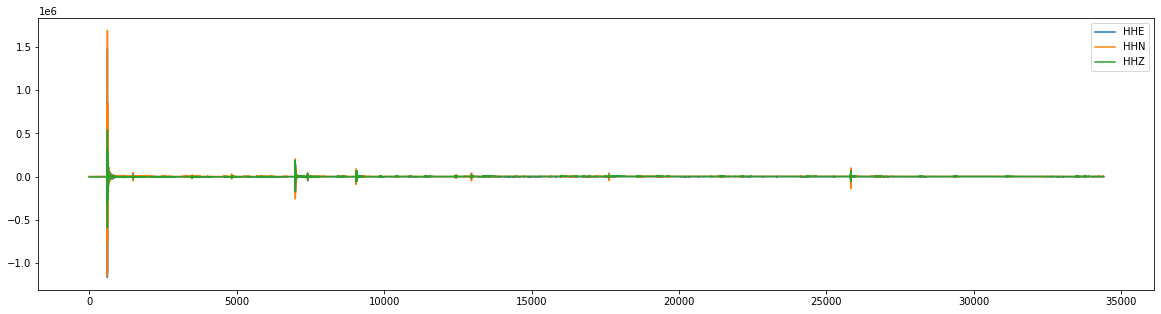

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
for i in range(3):
    ax.plot(stream[i].times(), stream[i].data, label=stream[i].stats.channel)
ax.legend();

#### Predict model on seismic stream

We can apply our varying models now to the seismic stream through the high level ```annotate``` method. This will output the charactersitic functions for the probability of a P-phase, S-phase, and noise class respectively.

In [ ]:
wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import time

In [ ]:
t0 = time.time()

pn_preds = pn_model.annotate(stream)
t1 = time.time()

eqt_preds = eqt_model.annotate(stream)
t2 = time.time()

gpd_preds = gpd_model.annotate(stream)
t3 = time.time()

In [ ]:
print('Prediction time for PhaseNet : ' + str(t1 - t0))
pn_preds

Prediction time for PhaseNet : 1.5760226249694824


3 Trace(s) in Stream:
NC.MINS..PhaseNet_P | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples
NC.MINS..PhaseNet_S | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples
NC.MINS..PhaseNet_N | 2020-04-11T14:26:37.005000Z - 2020-04-11T23:59:59.995000Z | 100.0 Hz, 3440300 samples

In [ ]:
print('Prediction time for EQTransformer : ' + str(t2 - t1))
eqt_preds

Prediction time for EQTransformer : 2.5237488746643066


3 Trace(s) in Stream:
NC.MINS..EQTransformer_Detection | 2020-04-11T14:26:42.005000Z - 2020-04-11T23:59:54.995000Z | 100.0 Hz, 3439300 samples
NC.MINS..EQTransformer_P         | 2020-04-11T14:26:42.005000Z - 2020-04-11T23:59:54.995000Z | 100.0 Hz, 3439300 samples
NC.MINS..EQTransformer_S         | 2020-04-11T14:26:42.005000Z - 2020-04-11T23:59:54.995000Z | 100.0 Hz, 3439300 samples

In [ ]:
print('Prediction time for GPD : ' + str(t3 - t2))
gpd_preds

Prediction time for GPD : 63.910861015319824


3 Trace(s) in Stream:
NC.MINS..GPD_P | 2020-04-11T14:26:39.005000Z - 2020-04-11T23:59:58.005000Z | 10.0 Hz, 343991 samples
NC.MINS..GPD_S | 2020-04-11T14:26:39.005000Z - 2020-04-11T23:59:58.005000Z | 10.0 Hz, 343991 samples
NC.MINS..GPD_N | 2020-04-11T14:26:39.005000Z - 2020-04-11T23:59:58.005000Z | 10.0 Hz, 343991 samples

We will also compare these ML methods with STA/LTA method. 

(Each component will be calculated individually and only vertical component will be used to detect P arrivals)

In [ ]:
from obspy.signal.trigger import plot_trigger
from obspy.signal.trigger import trigger_onset
from obspy.signal.trigger import recursive_sta_lta

fs = 100       # sampling rate
nsta = 5 * fs  # length of short window
nlta = 10 * fs # length of long window
thr_on  = 1.2  # trigger-on threshold
thr_off = 0.5  # trigger-off threshold

In [ ]:
stream_filtered = stream.copy()
stream_filtered.detrend('linear')
stream_filtered.taper(0.05)
stream_filtered.filter('bandpass', freqmin=3.0, freqmax=20.0,zerophase=False)

t4 = time.time()

cft_0 = recursive_sta_lta(stream_filtered[0].data, nsta, nlta)
cft_1 = recursive_sta_lta(stream_filtered[1].data, nsta, nlta)
cft_2 = recursive_sta_lta(stream_filtered[2].data, nsta, nlta)

t5 = time.time()


In [ ]:
print('Prediction time for recursive STA/LTA : ' + str(t5 - t4))

Prediction time for recursive STA/LTA : 0.03026580810546875


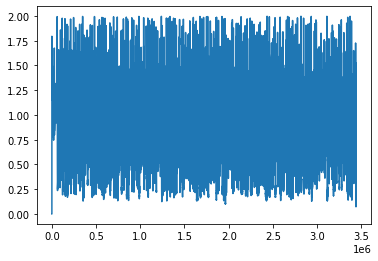

In [ ]:
plt.plot(cft_2)

In [ ]:
cft_2[:]

array([ 0.        ,  0.        ,  0.        , ...,  0.47662323,
        0.47614613,  0.47566951])

In [ ]:
sta_lta_preds = pn_preds.select(channel='PhaseNet_P').copy()
sta_lta_preds[0].data = cft_2
sta_lta_preds[0].stats.channel = 'STALTA_P'

In [ ]:
pn_preds[0].stats

         network: NC
         station: MINS
        location: 
         channel: PhaseNet_P
       starttime: 2020-04-11T14:26:37.005000Z
         endtime: 2020-04-11T23:59:59.995000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 3440300
           calib: 1.0

In [ ]:
sta_lta_preds[0].data

array([ 0.        ,  0.        ,  0.        , ...,  0.47662323,
        0.47614613,  0.47566951])

#### Step through to 'zoom in' on predictions

Enter window length in seconds, and define which model predictions you would like to plot

In [ ]:
wlength = 5 * 60 #@param

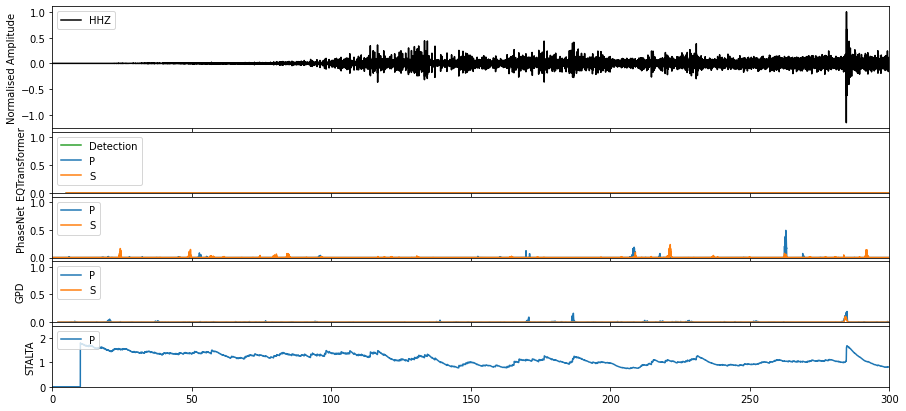

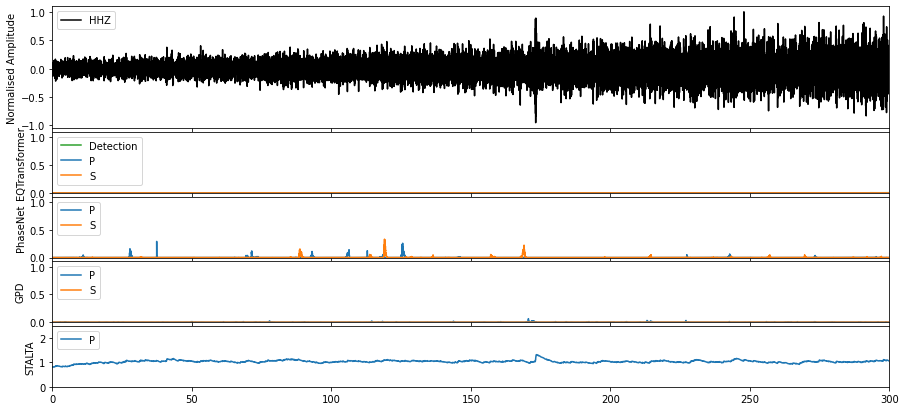

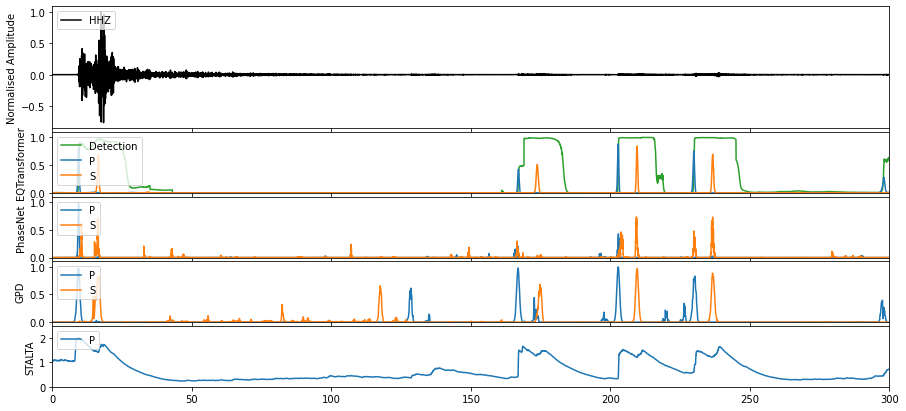

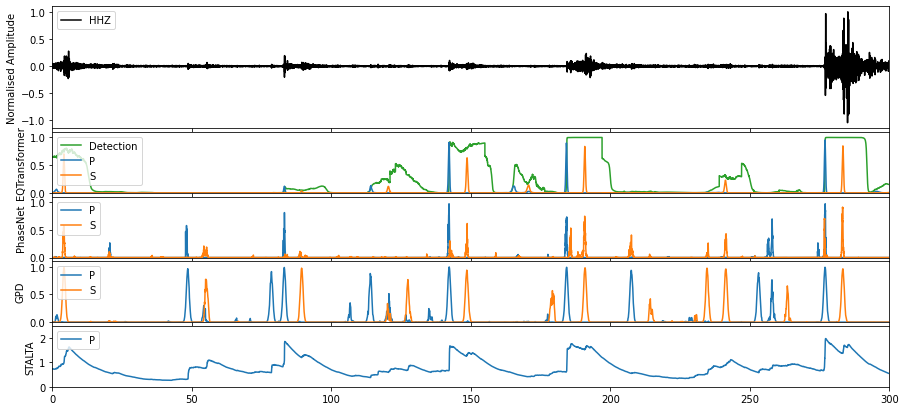

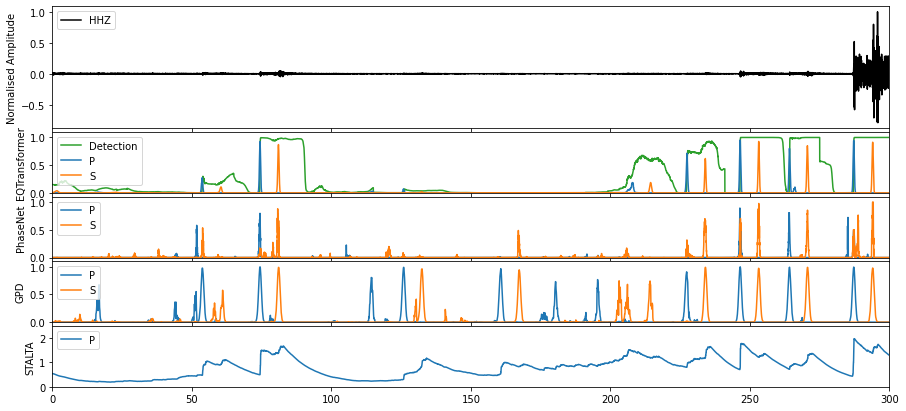

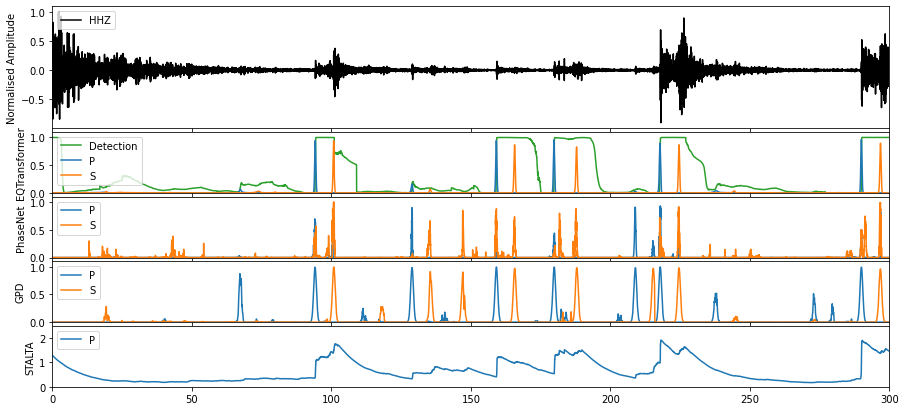

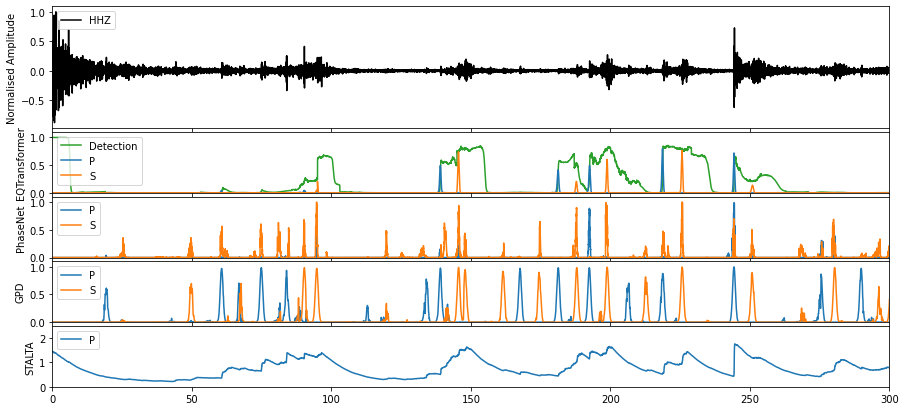

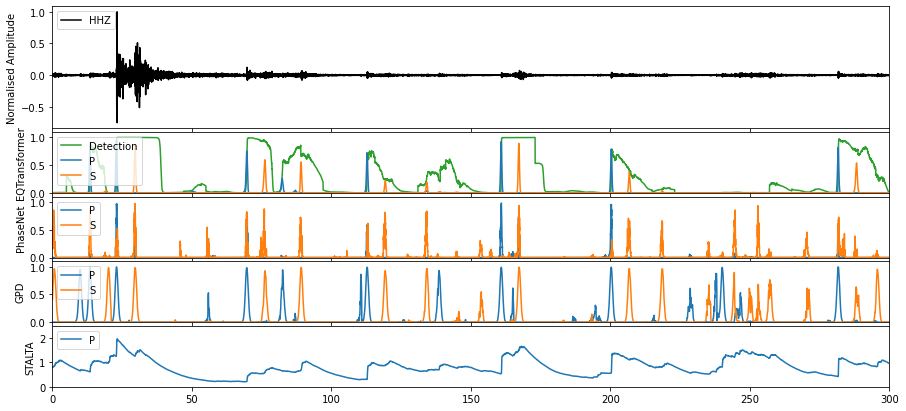

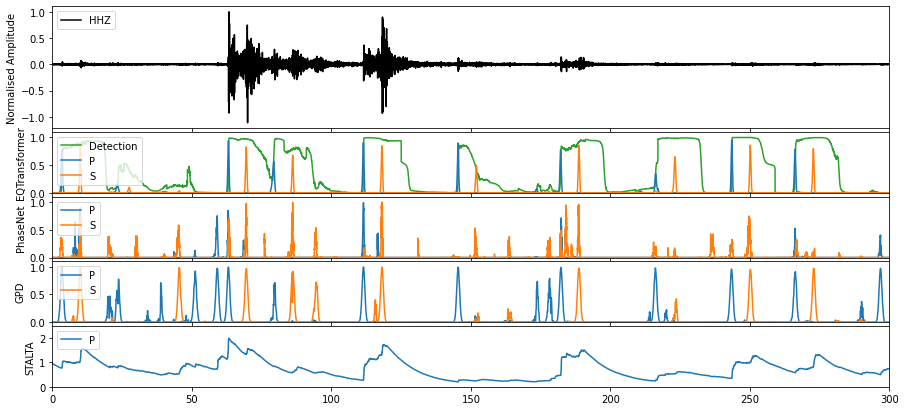

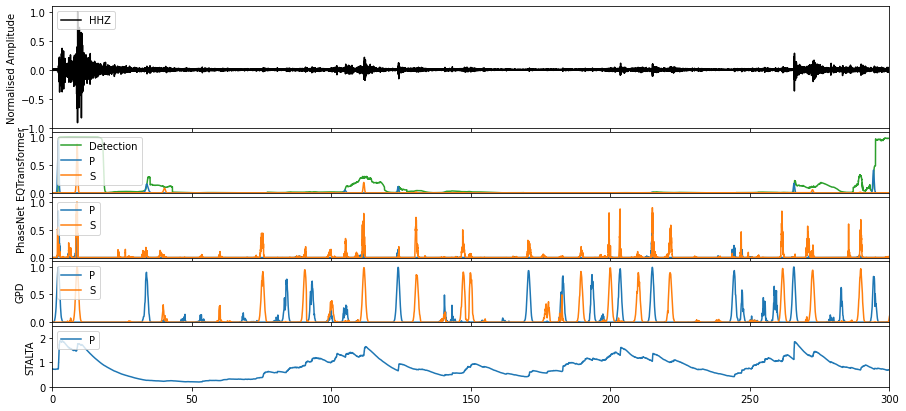

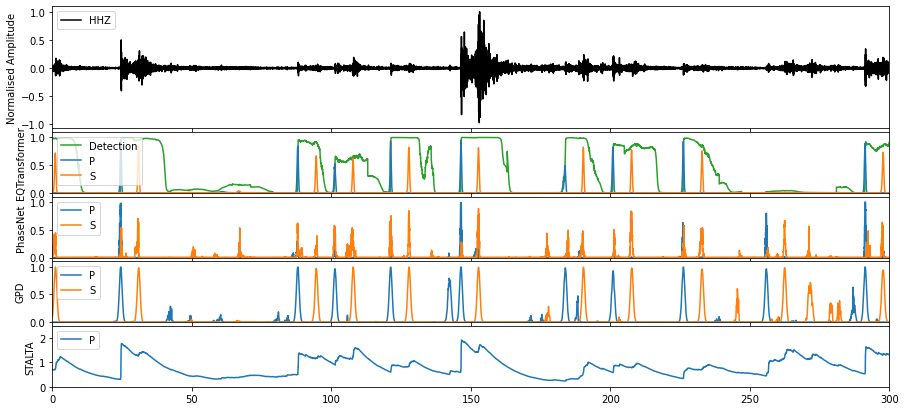

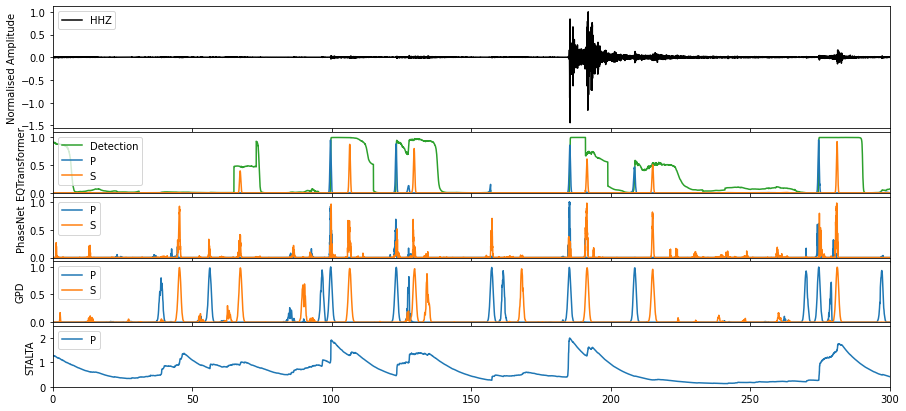

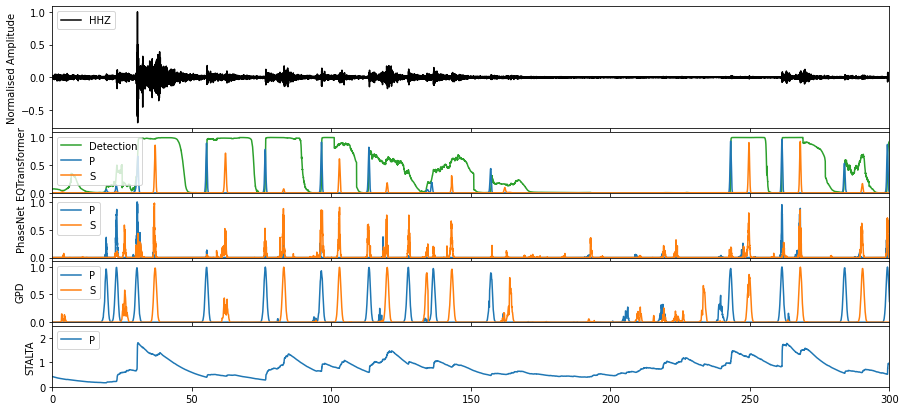

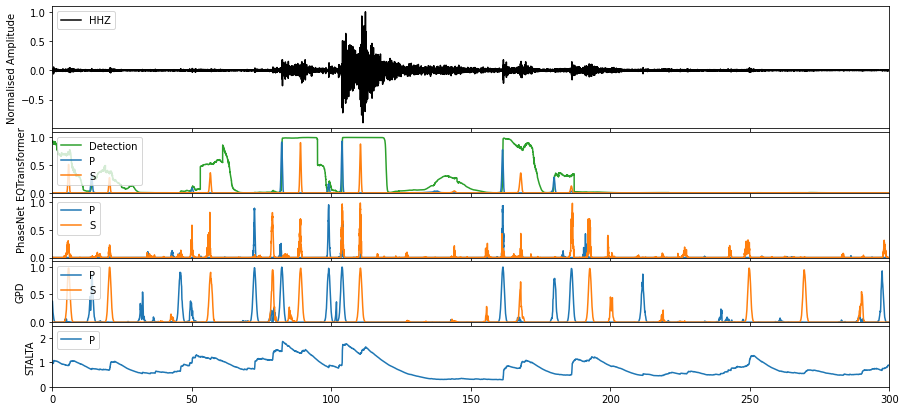

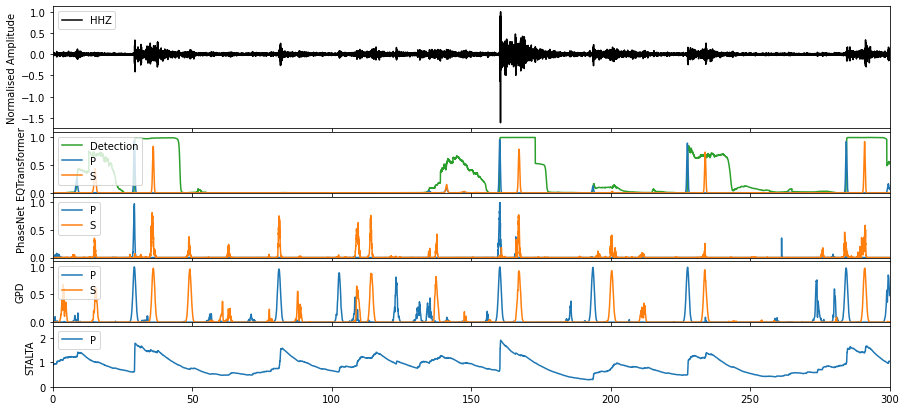

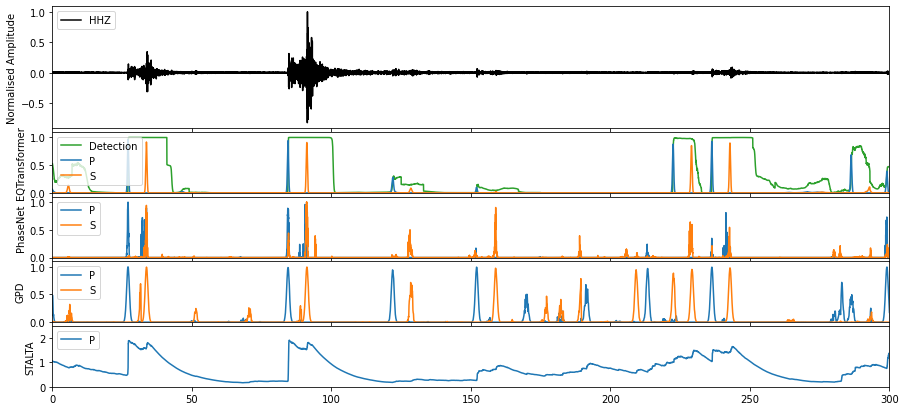

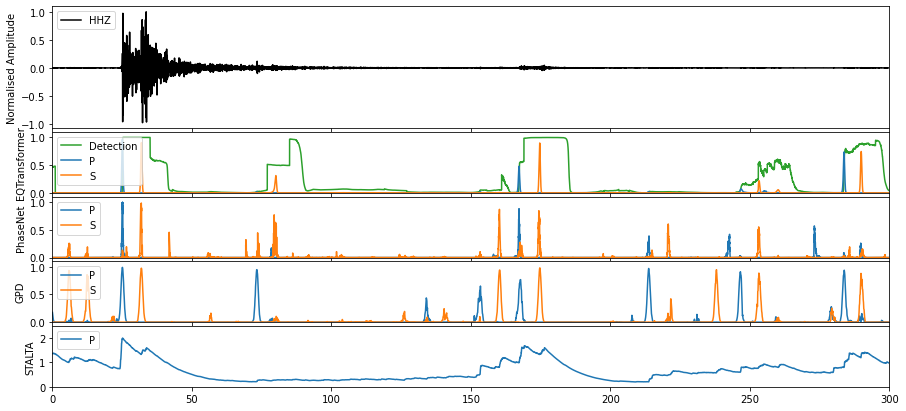

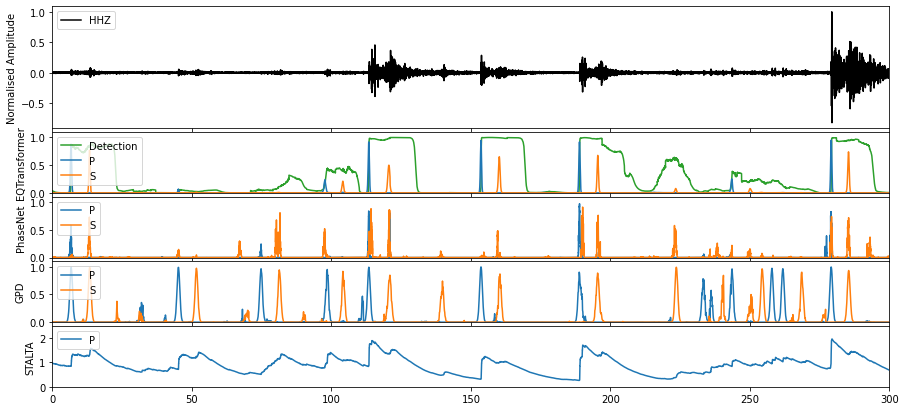

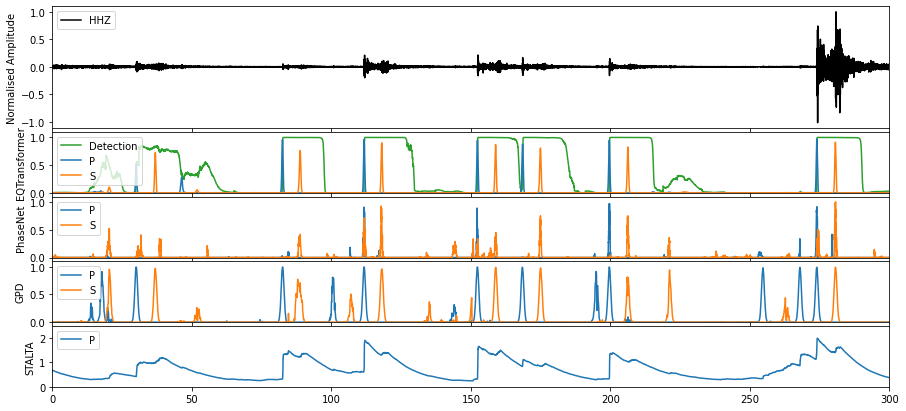

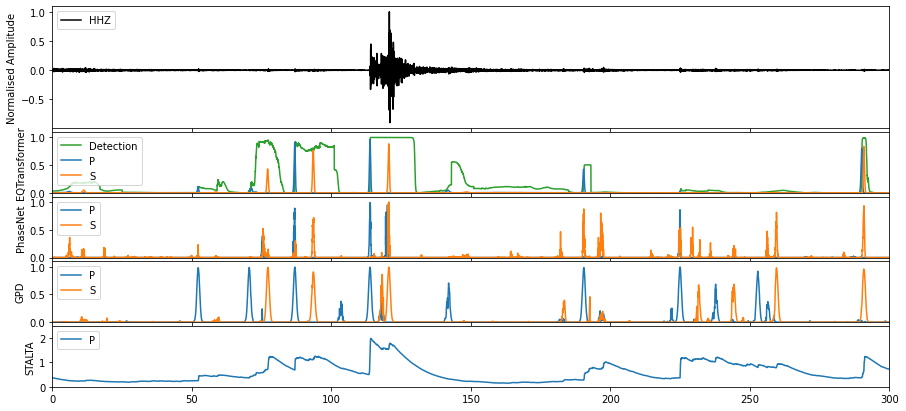

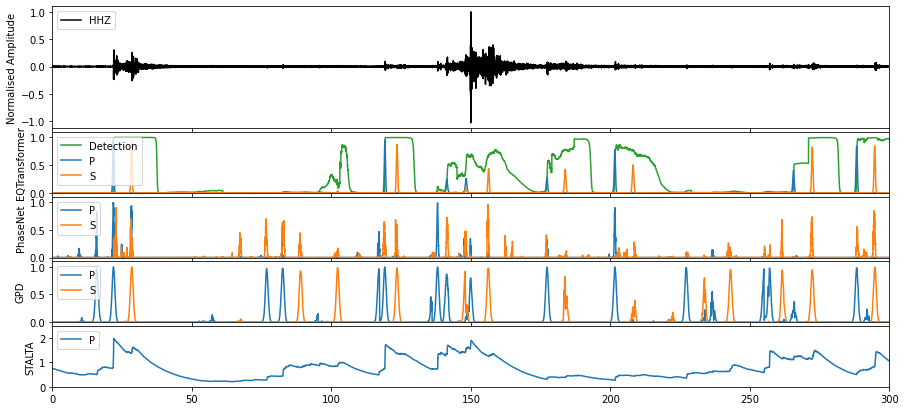

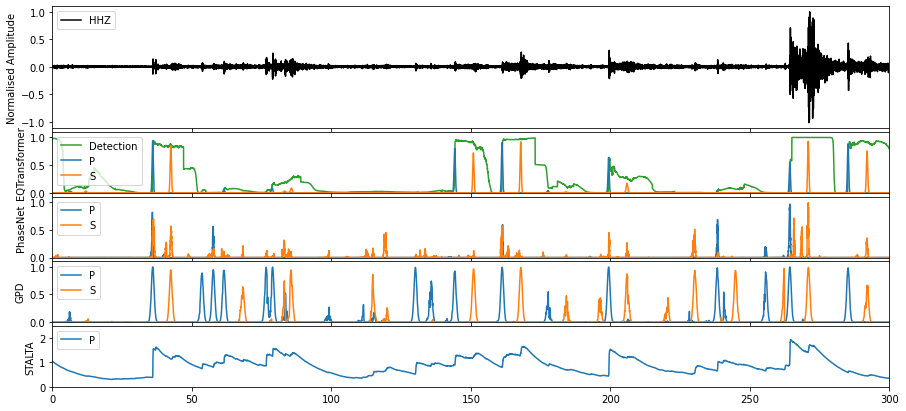

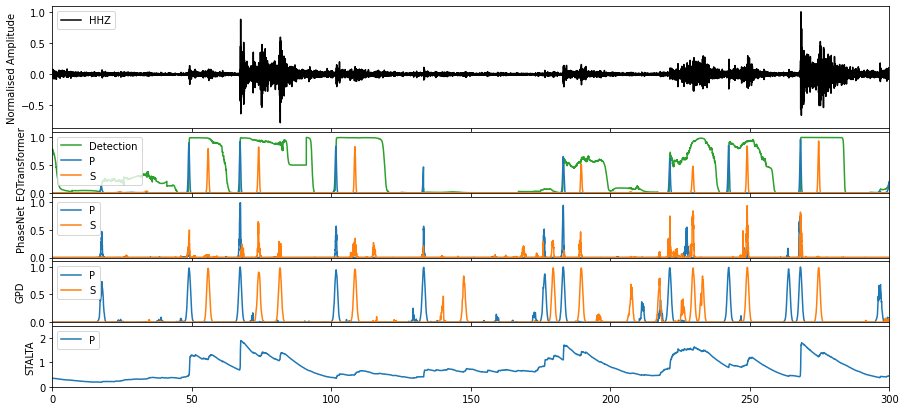

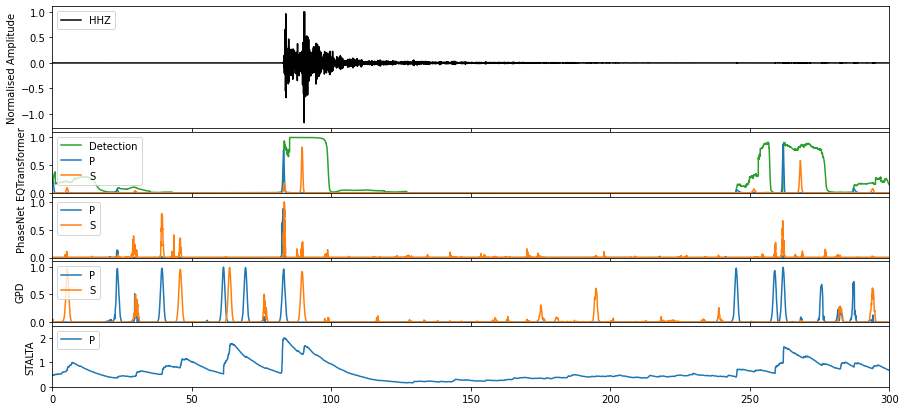

In [ ]:
color_dict = {"P": "C0", "S": "C1", "Detection": "C2"}
#time_plot = int(stream[0].stats.endtime - stream[0].stats.starttime)
time_plot = 3600*2

for s in range(0, time_plot, wlength):
    t0 = stream_filtered[0].stats.starttime + s
    t1 = t0 + wlength
    subst = stream_filtered.slice(t0, t1)

    fig, ax = plt.subplots(5, 1, figsize=(15, 7), sharex=True, gridspec_kw={'hspace' : 0.05, 'height_ratios': [2, 1, 1, 1,1]})
    
    for i, preds in enumerate([eqt_preds, pn_preds, gpd_preds, sta_lta_preds]):
        subpreds = preds.slice(t0, t1)
        offset = subpreds[0].stats.starttime - subst[0].stats.starttime
        for pred_trace in subpreds:
            model, pred_class = pred_trace.stats.channel.split("_")
            if pred_class == "N":
                # Skip noise traces
                continue
            c = color_dict[pred_class]
            ax[i + 1].plot(offset + pred_trace.times(), pred_trace.data, label=pred_class, c=c)
        ax[i + 1].set_ylabel(model)
        ax[i + 1].legend(loc=2)
        if i<3:
           ax[i + 1].set_ylim(0, 1.1)
        else:
           ax[i + 1].set_ylim(0, 2.5)
    
    ax[0].plot(subst[-1].times(), subst[-1].data / np.amax(subst[-1].data), 'k', label=subst[-1].stats.channel)
    ax[0].set_xlim(0, wlength)
    ax[0].set_ylabel('Normalised Amplitude')
    ax[3].set_xlabel('Time [s]')
    ax[0].legend(loc=2)
    plt.show()

If you would like to then make deterministic detections from the continuous characteristic functions, the ```classify``` method of each model will allow you to perform this task.

To get picks, we need to set thresholds for P and S wave detection. 

Some models (for example, EQTransformer ) may have another threshold for general detection (the probability of an earthquake's existense)

You can observe the plots above and make decisions on your thresholds.

#### Model : GPD

In [ ]:
detections_gpd = gpd_model.classify(stream)

In [ ]:
print(f"Number of picks made by GPD: {len(detections_gpd)}")

Number of picks made by GPD: 1865


With each pick storing the following information:

In [ ]:
detections_gpd[0].__dict__

{'end_time': 2020-04-11T14:36:47.005000Z,
 'peak_time': 2020-04-11T14:36:46.305000Z,
 'peak_value': 0.97069371,
 'phase': 'P',
 'start_time': 2020-04-11T14:36:46.005000Z,
 'trace_id': 'NC.MINS.'}

#### Model : PhaseNet

In [ ]:
detections_pn = pn_model.classify(stream,P_threshold=0.30, S_threshold=0.30)

In [ ]:
print(f"Number of picks made by PhaseNet: {len(detections_pn)}")

Number of picks made by PhaseNet: 2518


In [ ]:
detections_pn[0].__dict__

{'end_time': 2020-04-11T14:30:59.575000Z,
 'peak_time': 2020-04-11T14:30:59.555000Z,
 'peak_value': 0.354619,
 'phase': 'P',
 'start_time': 2020-04-11T14:30:59.555000Z,
 'trace_id': 'NC.MINS.'}

#### Model : EQTransformer

In [ ]:
detections_eqt,general_earthquake_detections = eqt_model.classify(stream,P_threshold=0.8, S_threshold=0.8)

In [ ]:
print(f"Number of picks made by EQTransformer: {len(detections_eqt)}")

Number of picks made by EQTransformer: 582


In [ ]:
print(f"Number of earthquakes made by EQTransformer: {len(general_earthquake_detections)}")

Number of earthquakes made by EQTransformer: 448


In [ ]:
general_earthquake_detections[0].__dict__

{'end_time': 2020-04-11T14:37:03.665000Z,
 'peak_value': 0.97193515,
 'start_time': 2020-04-11T14:36:46.525000Z,
 'trace_id': 'NC.MINS.'}

In [ ]:
detections_eqt[0].__dict__

{'end_time': 2020-04-11T14:36:46.635000Z,
 'peak_time': 2020-04-11T14:36:46.375000Z,
 'peak_value': 0.81695884,
 'phase': 'P',
 'start_time': 2020-04-11T14:36:46.335000Z,
 'trace_id': 'NC.MINS.'}

#### Model : Recursive STA/LTA

In [ ]:
on_off = trigger_onset(cft_2,thr_on,thr_off)

In [ ]:
print(f"Number of earthquakes made by recursive STA/LTA: {len(on_off)}") 

Number of earthquakes made by recursive STA/LTA: 350


In [ ]:
stream[0].stats.starttime + on_off[0][0]/fs

2020-04-11T14:26:47.005000Z